# Problem 2 and 3

## Motion field and parallax
- To find image velocity v, differentiate x=(x,y) with respect to t(using quotient rule):

$x = f\frac{X}{Z}$ 
$$ v_{x} = f\frac{ZV_{x} - V_{z}X}{Z^{2}} = \frac{fV_{x} - V_{z}x}{Z}$$

- Similarly for y

$y = f\frac{Y}{Z}$
$$ v_{y} = f\frac{ZV_{y} - V_{z}Y}{Z^{2}} = \frac{fV_{y} - V_{z}y}{Z}$$

$$ v = \frac{1}{Z}(v_{0} - V_{z}x), v_{0} = (fV_{x}, fV_{y}) $$ 

# Optical Flow
- apparent motion of brightness patters in the image
- Ideally optical flow would be same as motion field given: 
    - Brightness constantcy: projection of the same point looks the same in every frame
    - Small motion: points do not move very far
    - Spatial Coherence: points move like their neighbors
- Brightness Constancy Equation:

$$ I(x,y,t-1) = I(x+u(x,y), y + v(x,y), t)$$

- Linearizing the right size using Taylor Series Expansion

$$I(x,y,t-1) \approx I(x,y,t)+I_{x}.u(x,y)+I_{y}.v(x,y)$$

- Hence, $I_{x}.u + I_{y}.v + I_{t} \approx 0$

#### So here we have one equation and two unknowns so how do we solve it. We take an approach of using multiple points and create a system of linear equations to solve the problem

- We setup the problem as a least squares problem as we did for camera calibration and homography

$$ \begin{bmatrix} I_{x}(p1) & I_{y}(p1) \\ ... & ... \\ I_{x}(p25) & I_{y}(p25)\end{bmatrix} \begin{bmatrix} u \\ v\end{bmatrix} = -\begin{bmatrix} I_{t}(p1) \\ ... \\ I_{t}(p25) \end{bmatrix}  A \space d=b$$

$$ Solution \space given \space by \space (A^{T}A) \space d = A^{T} \space b $$

- This is the Lucas Kanade Flow Equation

- Recall from Harris Corner detection $M = A^{T}A$ is the second moment matrix.

# Here we compute the $I_{x}, \space I_{y} \space and \space I_{t}$ for the motion equations

In [34]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
def motion_constraints(Iref, Inext):
    kernel_x = np.array([[-1., 1.], [-1., 1.]])*.25
    kernel_y = np.array([[-1., -1.], [1., 1.]])*.25
    kernel_t = np.array([[1., 1.], [1., 1.]])*.25
    Iref = Iref / 255. # normalize pixels
    Inext = Inext / 255. # normalize pixels
    mode = 'same'
    Ix = signal.convolve2d(Iref, kernel_x, boundary='symm', mode=mode)
    Iy = signal.convolve2d(Iref, kernel_y, boundary='symm', mode=mode)
    It = signal.convolve2d(Inext, kernel_t, boundary='symm', mode=mode) + signal.convolve2d(Iref, -kernel_t, boundary='symm', mode=mode)
    return Ix, Iy, It

In [35]:
frame0 = cv2.imread('Frame0.jpg')
frame0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
frame1 = cv2.imread('Frame1.jpg')
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
frame1 = cv2.resize(frame1, (87,87))

In [36]:
Ix, Iy, It = motion_constraints(frame0, frame1)

# After we have the derivatives, we compute the momentsand setup the equations to find the areas of least response and then solve the equation to find u and v as described above

In [159]:
def lucas_kanade(Iref, Inext, window_size=3, tau=1e-1):
    kernel_x = np.array([[-1., 1.], [-1., 1.]])*.25
    kernel_y = np.array([[-1., -1.], [1., 1.]])*.25
    kernel_t = np.array([[1., 1.], [1., 1.]])*.25
    Iref = Iref / 255. # normalize pixels
    Inext = Inext / 255. # normalize pixels
    mode = 'same'
    fx = signal.convolve2d(Iref, kernel_x, boundary='symm', mode=mode)
    fy = signal.convolve2d(Iref, kernel_y, boundary='symm', mode=mode)
    ft = signal.convolve2d(Inext, kernel_t, boundary='symm', mode=mode) + signal.convolve2d(Iref, -kernel_t, boundary='symm', mode=mode)
    w= window_size//2
    u = np.zeros(Iref.shape)
    v = np.zeros(Iref.shape)
    # within window window_size * window_size
    for i in range(w, Iref.shape[0]-w):
        for j in range(w, Iref.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            b = np.reshape(It, (It.shape[0],1)) # get b here
            A = np.vstack((Ix, Iy)).T # get A here

            if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau:
                nu = np.matmul(np.linalg.pinv(A), b) # get velocity here
                u[i,j]=nu[0]
                v[i,j]=nu[1]
    plt.imshow(Iref, cmap='gray')
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            if abs(u[i,j])>tau or abs(v[i,j])>tau:
                plt.arrow(j,i,v[i,j],u[i,j],head_width = 2, head_length = 2, color = 'r')

    return (u,v)

# Output of Lucas Kanade flow

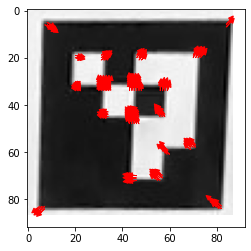

In [160]:
u,v = lucas_kanade(frame0, frame1, window_size=5)

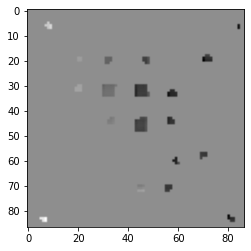

In [149]:
plt.imshow(u, cmap='gray')

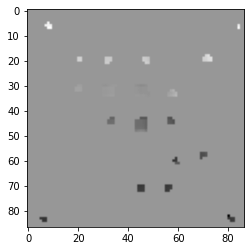

In [150]:
plt.imshow(v, cmap='gray')

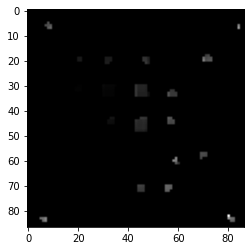

In [151]:
plt.imshow(u**2+v**2, cmap='gray')

<ipython-input-152-aff5df2ea950>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(np.arctan(u/v), cmap='gray')


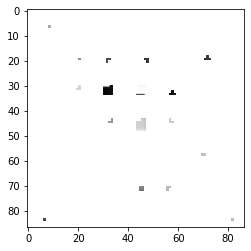

In [152]:
plt.imshow(np.arctan(u/v), cmap='gray')

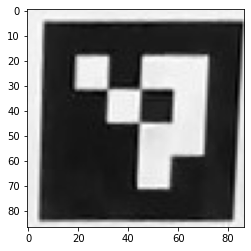

In [153]:
plt.imshow(frame0, cmap='gray')

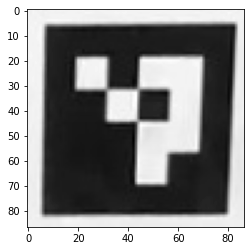

In [154]:
plt.imshow(frame1, cmap='gray')